<h2 style="margin-bottom:0px;"><center>Restricted Hartree–Fock for Helium</center></h2>

<p style="text-align: center; margin-top: 10px; margin-bottom: 0px;">
    By <a target="_blank" href="https://github.com/yueyericardo">$Richard\;Xue$</a>&nbsp;/&nbsp;
    <a target="_blank" href="https://github.com/yueyericardo/hartree-fock">$Source\;code$</a>
</p>

<p style="text-align: center; margin-top: 5px; margin-bottom: 0px;">
    $2018/12/07$
</p>

<p style="text-align: center; margin-top: 5px;">
    <a target="_blank" href="https://yyrcd.com/hf/he.html">$Helium$</a>&nbsp;/&nbsp;
    <a target="_blank" href="https://yyrcd.com/hf/li.html">$Lithium$</a>&nbsp;/&nbsp;    
    <a target="_blank" href="https://yyrcd.com/hf/be.html">$Beryllium$</a>
</p>


In [1]:
import sympy as sp
from sympy import oo
import numpy as np
from itertools import product
from scipy.linalg import eig
from sympy import diff
import time as time
import matplotlib.pyplot as plt
from sympy.plotting import plot
# %matplotlib notebook 
%matplotlib inline
from IPython.display import Math
sp.init_printing()

r, r1, r2, zeta, zeta1, zeta2 = sp.symbols("r, r1, r2, zeta, zeta1, zeta2")
n = sp.Symbol('n',integer=True)

<h2><center>Part 1 Function Definition</center></h2>

### Define STO function
<p><a href="https://en.wikipedia.org/wiki/Laplace_operator">$STO$</a>$ \; function \; has \; format \; of: \; Nr^{n-1}e^{-r\zeta}$</p>


In [2]:
def STO(zeta, n, r=r):
    return (2*zeta)**n*(2*zeta/sp.factorial(2*n))**(1/2)*r**(n-1)*sp.exp(-zeta*r)

print("For example: STO for 1s")
STO(zeta, 1)

For example: STO for 1s


### Overlap Integrate

$S = \int_{0}^\infty f_1^* f_2 \; r^2dr$

In [3]:
# S Overlap Integrate
def S_int(f1, f2):
    return sp.integrate(f1*f2*r*r ,(r, 0, +oo))

### Hamiltonian core

H core = kinetics energy + electron and nuclear potential energy

$H = \int_{0}^\infty f_1 \hat{H} f_2 \; r^2dr$

$H = \int_{0}^\infty f_1 ((-\dfrac{1}{2}) \nabla^2 - \dfrac{Z_{\alpha}}{r})f_2 \; r^2 dr$

<p><a href="https://en.wikipedia.org/wiki/Laplace_operator">$Laplace \; operator: $</a> $\nabla^2$</p>
<p><left><img class = "none"style="text-align: center; margin-left:0px" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b4a3135d1cc01d19309d36c749aaef4a48dc81da"></left></p>

$\therefore H = \int_{0}^\infty f_1 ((-\dfrac{1}{2}) \dfrac{1}{r} \dfrac{\partial}{\partial r} \dfrac{\partial}{\partial r} r f_2 - \dfrac{Z_{\alpha}}{r}r^2 f_2 )dr$

**reminder:** change the Z of nucleus if you want to run for other atom

In [4]:
# H core = kinetics energy + electron and nuclear potential energy
def H_int(f1, f2, Z):
    return sp.integrate(f1*(-((1/2)*(1/r)*diff(diff(r*f2, r), r))-((Z/r)*f2))*r*r, (r,0,+oo))

In [5]:
# Returns the core hamiltonian matrix
def H_matrix(fs, Z):

    H = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            H[i, j] =  H_int(fs[i], fs[j], Z)

    return H    

# Returns the overlap matrix
def S_matrix(fs):

    S = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            S[i, j] =  S_int(fs[i], fs[j])

    return S  

### Two elecron repulsion integral
$(rs|tu) = \int \int \dfrac{f_r^*(1) f_s(1) f_t^*(2) f_u(2)}{r_{12}} \; dv_1 dv_2 $

For 1s 2s orbital

$(rs|tu)  = \int_{0}^\infty \int_{0}^\infty \dfrac{f_r^*(1) f_s(1) f_t^*(2) f_u(2)}{r_{12}} \; r_1^2dr_1\; r_2^2dr_2  $

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1)  \; r_1^2dr_1\int_{0}^\infty \frac{ f_t^*(2) f_u(2)}{r_{12}}\; r_2^2dr_2  $

From problem 9.14 in quantum_chemistry by levine

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1)  \; r_1^2dr_1\int_{0}^\infty \frac{ f_t^*(2) f_u(2)}{r_{>}}\; r_2^2dr_2  $

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1)  \; r_1^2dr_1(\int_{0}^{r_1} \frac{ f_t^*(2) f_u(2)}{r_{1}}\; r_2^2dr_2 + \int_{r_1}^\infty \frac{ f_t^*(2) f_u(2)}{r_{2}}\; r_2^2dr_2)  $

$Let \; B= \int_{0}^{r_1} \frac{ f_t^*(2) f_u(2)}{r_{1}}\; r_2^2dr_2 + \int_{r_1}^\infty \frac{ f_t^*(2) f_u(2)}{r_{2}}\; r_2^2dr_2$

$(rs|tu) = \int_{0}^\infty f_r^*(1) f_s(1) B \; r_1^2 dr_1  $



In [6]:
def Repulsion_electron(zetas):
    
    f1=STO(zetas[0][0], zetas[0][1], r1)
    f2=STO(zetas[1][0], zetas[1][1], r1)
    f3=STO(zetas[2][0], zetas[2][1], r2)
    f4=STO(zetas[3][0], zetas[3][1], r2)
    fs = [f1, f2, f3, f4]
    
    B = (1/r1)*sp.integrate(f3*f4*r2*r2 ,(r2, 0, r1)) + sp.integrate((1/r2)*f3*f4*r2*r2 ,(r2, r1, +oo))
    A = sp.integrate(f1*f2*r1*r1*B ,(r1, 0, +oo))
    return A

### Density matrix
$ P_{tu} =2 \sum_{j=1}^{n/2}c_{tj}^* c_{uj} $

**Reminder:** P need to be changed if the atom have unpaired electron

In [7]:
# Calculates Density matrix
def P_matrix(Co):

    P = np.zeros([Co.shape[0], Co.shape[0]])

    for t in range(Co.shape[0]):
        for u in range(Co.shape[0]):
            for j in range(int(Co.shape[0]/2)):
                P[t][u] += 2* Co[t][j]*Co[u][j]
    return P            

### Fock matrix
$ F_{rs} = H_{rs}^{core} + \sum_{t=1}^{b} \sum_{t=1}^{b}P_{tu}[(rs|tu)- \frac{1}2(ru|ts)] $  

$G = \sum_{t=1}^{b} \sum_{t=1}^{b}P_{tu}[(rs|tu)- \frac{1}2(ru|ts)]$ 

$ F_{rs} = H_{rs}^{core} + G $  

$In\;G \;one\;is\;coulombic\;repulsion,\;another\;is\;exchange\;energy$

In [8]:
def R_matrix(zetas):
    R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))

    rs = list(product(range(len(zetas)),repeat=2))
    tu = list(product(range(len(zetas)),repeat=2))

    for r, s in rs:
        for t, u in tu:
            R[r,s,t,u] = Repulsion_electron((zetas[r], zetas[s], zetas[t], zetas[u]))
    return R

# Caculate G Matrix
def G_matrix(zetas, Co, R):

    G = np.zeros((Co.shape[0], Co.shape[0]))

    P = P_matrix(Co)
    
    rs = list(product(range( Co.shape[0]),repeat=2))
    tu = list(product(range( Co.shape[0]),repeat=2))

    for r, s in rs:
        g = 0
        for t, u in tu:
            int1 = R[r, s, t, u]
            int2 = R[r, u, t, s]
#             print('({0}{1}|{2}{3}): {4}'.format(r, s, t, u, int1))
            g+= P[t, u] * (int1 - 0.5 * int2)
        G[r, s] = g
    return G

# Returns the Fock matrix
def F_matrix(fs, Z, zetas, Co, R):
    return H_matrix(fs, Z) + G_matrix(zetas, Co, R)

### Solve Hartree-Fork equation

$det(F_{rs}-\epsilon_i S_{rs} = 0)$  

$The\;energy\;returned\;is\;the\;orbital\;energy\;for\;1\;electron$

In [9]:
# slove secular equation, return the energy and improved coeffients
# the energy here is orbital energy for 1 electron
def secular_eqn(F, S):
    ei, C = eig(F, S)
    
    # sort eigvalue and eigvector from lower to higher
    idx = ei.argsort()[::1]   
    ei = ei[idx]
    C = C[:,idx]

    # eigvector from scipy.linalg.eig is not normalized, which is a bug
    # this is to fix it
    Co = np.zeros((C.shape[0],C.shape[0]))
    inte = np.matmul(np.matmul(C.T, S), C)
    for i in range(C.shape[0]):
        for j in range(C.shape[0]):
            Co[j][i]=C[j][i]/np.sqrt(inte[i][i])

    return ei, Co

### Return atom energy
$ E_{HF} = \sum_{i=1}^{2/n}\epsilon  +\frac{1}2 \sum_{r=1}^{b} \sum_{s=1}^{b}P_{rs}H_{rs}+V_{NN} $

In [10]:
# return energy of atom
def get_E0(e, P, H):
    
    E0 = 0
    for i in range(int(e.shape[0]/2)):
        E0 += e[i].real 
    E0 = E0 + 0.5*(P*H).sum()
    return E0 

<h2><center>Part 2 Hartree Fork Iteration (Main Process)</center></h2>

- Initialization
    1. initializing Co (coefficients) without considering electron repulsion
    1. Solve Hartree-Fork equation with H_matrix and S_matrix to get initial Co


- Iteration
	1. Using Co, we can get P_matrix (electron density)
	2. Using P_matrix, H_matrix, G_matrix => F_matrix
	3. Solve Hartree-Fork equation with F_matrix and S_matrix to get improved orbital energy and Co, which also means improved orbital functions.
	4. Using improved Co, return to step 1

------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion integral ------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

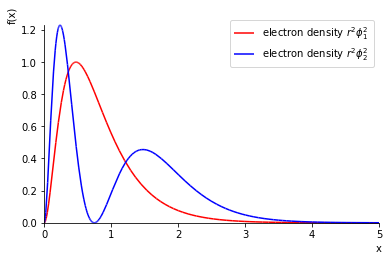

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------ Iteration 1 ------------------------------
------- Iteration 1 needs more time to caculate Repulsion Integral ------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

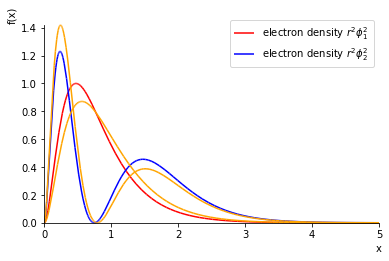

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.4 s
------------------------------ Iteration 2 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

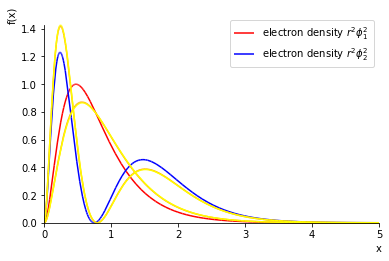

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.5 s
------------------------------ Iteration 3 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

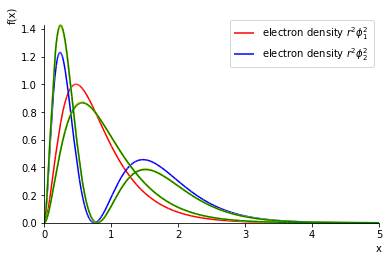

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.5 s
------------------------------ Iteration 4 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

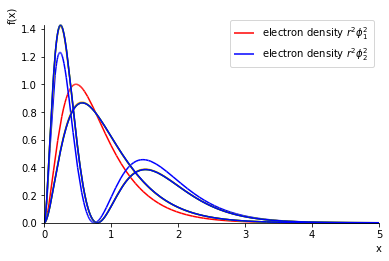

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.6 s
------------------------------ Iteration 5 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

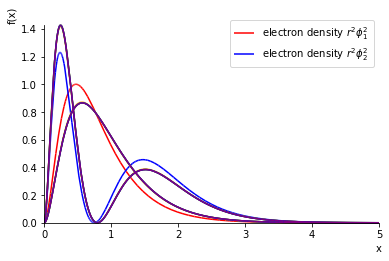

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.5 s
------------------------------ Iteration 6 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

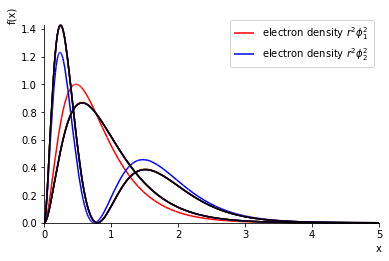

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.6 s
------------------------------ Iteration 7 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

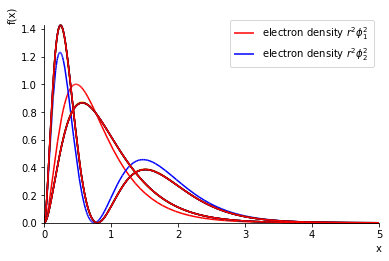

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.6 s
------------------------------ Iteration 8 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

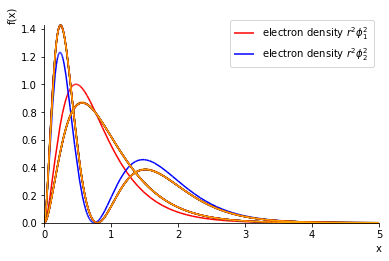

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.6 s
------------------------------ Iteration 9 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

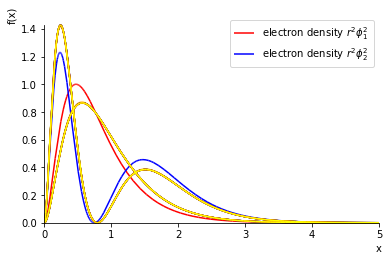

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.7 s
------------------------------ Iteration 10 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

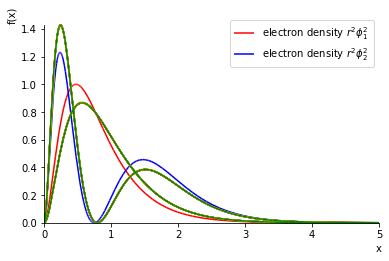

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 0.7 s


In [18]:
# input for zeta
zetas = [[1.45, 1], [2.91, 1]]
# input nuclear charge (element number)
Z = 2

# build basis function
f1=STO(zetas[0][0], zetas[0][1])
f2=STO(zetas[1][0], zetas[1][1])
fs = [f1, f2]

# initialization
R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))
H = H_matrix(fs, Z)
S = S_matrix(fs)
e, Co = secular_eqn(H, S)
P = P_matrix(Co)
scf_H = get_E0(e, P, H)

##############################################print information below#################################################
print('-'*30, "Initialization", '-'*30)
print('-'*25, "Ignore repulsion integral", '-'*24)
display(Math('Basis \ Function:'))
display(Math('\chi = N r^{n - 1}e^{-r \zeta} ')) 
display(Math('\zeta_1 = {0} \quad \zeta_2 = {1}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), ))) 
display(Math('Orbitals:'))
display(Math(' \phi_1 = c_{11} \chi_1 + c_{21} \chi_2 '))
display(Math(' \phi_2 = c_{12} \chi_1 + c_{22} \chi_2 '))    
display(Math('c11 = {0} \quad c21 = {1} '.format(format(Co[0][0], '0.3f'), format(Co[1][0], '0.3f')))) 
display(Math('c12 = {0} \quad c22 = {1} '.format(format(Co[0][1], '0.3f'), format(Co[1][1], '0.3f'))))  

# plot density graph
colorlist = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black']
phi1 = Co[0,0]*f1+Co[1,0]*f2
phi2 = Co[0,1]*f1+Co[1,1]*f2
density_1 = phi1*phi1*r*r
density_2 = phi2*phi2*r*r    
p = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), show = False, legend = True)
p[0].label = 'electron density $r^2 \phi_1^2$ '
p[1].label = 'electron density $r^2 \phi_2^2$ '    
p[0].line_color = colorlist[0]
p[1].line_color = 'blue'
p.show()
# print energy result
display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(e[0].real, '0.3f'))))    
display(Math(' \epsilon_2 \; for \; \phi_1 = {0} '.format(format(e[1].real, '0.3f'))))        
display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))  
##############################################print information above#################################################

for i in range(10):
    print('-'*30, "Iteration", i + 1, '-'*30)
    if(i==0):
        print('-'*7, "Iteration 1 needs more time to caculate Repulsion Integral", '-'*6)
        start = time.time()
        R = R_matrix(zetas)
    else:
        start = time.time()
    F = F_matrix(fs, Z, zetas, Co, R)
    S = S_matrix(fs)
    e, Co = secular_eqn(F, S)
    P = P_matrix(Co)
    scf_H = get_E0(e, P, H)
    ##########################################print information below#################################################
    # print information
    display(Math('\zeta_1 = {0} \quad \zeta_2 = {1}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), ))) 
    display(Math('Orbitals:'))    
    display(Math(' \phi_1 = c_{11} \chi_1 + c_{21} \chi_2 '))
    display(Math(' \phi_2 = c_{12} \chi_1 + c_{22} \chi_2 '))    
    display(Math('c11 = {0} \quad c21 = {1} '.format(format(Co[0][0], '0.3f'), format(Co[1][0], '0.3f')))) 
    display(Math('c12 = {0} \quad c22 = {1} '.format(format(Co[0][1], '0.3f'), format(Co[1][1], '0.3f'))))      
    # plot density graph
    phi1 = Co[0,0]*f1+Co[1,0]*f2
    phi2 = Co[0,1]*f1+Co[1,1]*f2
    density_1 = phi1*phi1*r*r
    density_2 = phi2*phi2*r*r    
    p1 = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), show = False, legend = True)
    p1[0].label = None 
    p1[1].label = None     
    p1[0].line_color = colorlist[i+1]
    p1[1].line_color = colorlist[i+1]
    p.extend(p1)
    p.show() 
    # print energy result
    display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(e[0].real, '0.3f'))))    
    display(Math(' \epsilon_2 \; for \; \phi_1 = {0} '.format(format(e[1].real, '0.3f'))))        
    display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))    
    stop = time.time()
    print('Time used:',format(stop-start, '0.1f'),'s')
    ##########################################print information above#################################################    

Reference

[1] Levine, Quantum Chemistry, 7th Edition, chapter 14  
[2] C. Roetti and E. Clementi, J. Chem. Phys., 60, 4725 (1974)  
[3] Acosta C R. Restricted closed shell Hartree Fock Roothaan matrix method applied to Helium atom using   Mathematica[J]. European Journal of Physics Education, 2017, 5(1): 1-14.  
[4] [Simple Quantum Chemistry: Hartree-Fock in Python, 2018](http://nznano.blogspot.com/2018/03/simple-quantum-chemistry-hartree-fock.html)  
[5] [Helium hartree fork, prtkm, 2015](https://github.com/prtkm/helium-hartree-fock/)